In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
!gdown https://drive.google.com/drive/folders/19JWGJib5Y3PixVbsAf-EpYZZkkFvU6DC?usp=sharing

/usr/local/lib/python3.10/dist-packages/gdown/parse_url.py:35: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=None
  warnings.warn(
Downloading...
From: https://drive.google.com/drive/folders/19JWGJib5Y3PixVbsAf-EpYZZkkFvU6DC?usp=sharing
To: /content/drive/MyDrive/Colab Notebooks/500 Data/Colorectal Cancer/19JWGJib5Y3PixVbsAf-EpYZZkkFvU6DC?usp=sharing
1.64kB [00:00, 4.29MB/s]


In [57]:
import os
#os.chdir("/content/drive/My Drive/Colab Notebooks/Comp432Project/Dataset1/ColorectalCancer_")#100
os.chdir("/content/drive/My Drive/Colab Notebooks/500 Data/Colorectal Cancer") #500

In [58]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

import torch.optim as optim
from torchvision import datasets, transforms

import os
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import classification_report


print(torch.cuda.is_available())

torch.cuda.empty_cache()

True


In [59]:
def get_data():
    #data_dir = '/content/drive/My Drive/Colab Notebooks/Comp432Project/Dataset1/ColorectalCancer_' #100
    data_dir = '/content/drive/My Drive/Colab Notebooks/500 Data/Colorectal Cancer' #500
    transform = transforms.Compose([transforms.ToTensor(),transforms.Resize((224,224))])
    data_set = datasets.ImageFolder(root=data_dir, transform=transform)
    print(data_set.classes)

    n = len(data_set)  # total number of examples
    n_test = int(0.20 * n)  # take ~20% for test
    for x in range(0, 9):  # rounding it to be divisible by 4
        n_test += 1
        if n_test % 4 == 0:
            break
    train_set, test_set = torch.utils.data.random_split(data_set, [n - n_test, n_test])

    train = DataLoader(train_set, batch_size=32, shuffle=True)
    test = DataLoader(test_set, batch_size= 10, shuffle=False)


    return train, test


In [60]:

# Defining the Model
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        # First convolutional layer (conv1)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # Second convolutional layer (conv2)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection (if needed)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(x)
        out = self.relu(out)

        return out


#
class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(64, 64, 2, stride=1)
        self.layer2 = self.make_layer(64, 128, 2, stride=2)
        self.layer3 = self.make_layer(128, 256, 2, stride=2)
        self.layer4 = self.make_layer(256, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, 1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x



In [61]:
# Getting the data
train, test= get_data()
# Instanciating the ResNet18 Class created earlier and Assigning it as our model
model = ResNet18(3)

# The loss function
criterion = nn.CrossEntropyLoss()
#
optimizer = optim.Adam(model.parameters(), lr=0.001)
# momentum=0.9

# Using Cuda cores for the training
model=model.to(torch.device("cuda:0"))


['MUS', 'NORM', 'STR']


train
Epoch 1/20, Loss: 0.557551383972168
Epoch 1/20, Loss: 0.3584713041782379
Epoch 1/20, Loss: 0.6807259917259216
Epoch 1/20, Loss: 0.4501453638076782
Epoch 1/20, Loss: 0.37734073400497437
Epoch 1/20, Loss: 0.45389315485954285
Epoch 1/20, Loss: 0.9333130717277527
Epoch 1/20, Loss: 0.4376406669616699
Epoch 1/20, Loss: 0.49073565006256104
Epoch 1/20, Loss: 0.4021502435207367
Epoch 1/20, Loss: 0.46714454889297485
Epoch 1/20, Loss: 0.42474910616874695
Epoch 1/20, Loss: 0.40152496099472046
Epoch 1/20, Loss: 0.5690895915031433
Epoch 1/20, Loss: 0.42483747005462646
Epoch 1/20, Loss: 0.5122581124305725
Epoch 1/20, Loss: 0.3441375195980072
Epoch 1/20, Loss: 0.30312469601631165
Epoch 1/20, Loss: 0.3717544972896576
Epoch 1/20, Loss: 0.3361315131187439
Epoch 1/20, Loss: 0.504269540309906
Epoch 1/20, Loss: 0.21055659651756287
Epoch 1/20, Loss: 0.6187661290168762
Epoch 1/20, Loss: 0.6309951543807983
Epoch 1/20, Loss: 0.25817936658859253
Epoch 1/20, Loss: 0.5087032914161682
Epoch 1/20, Loss: 0.2517

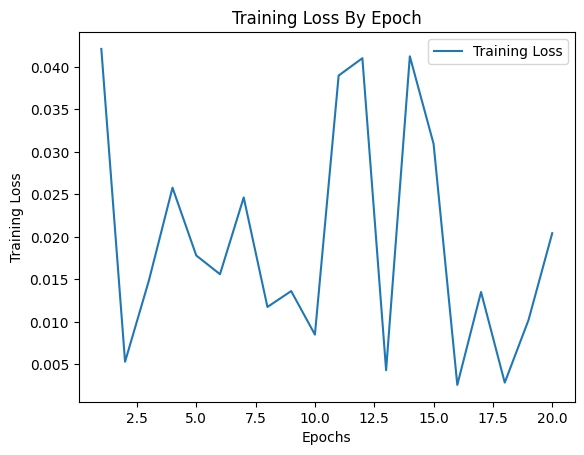

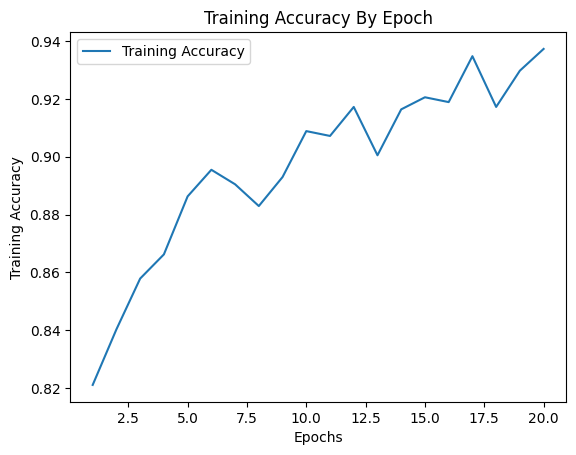

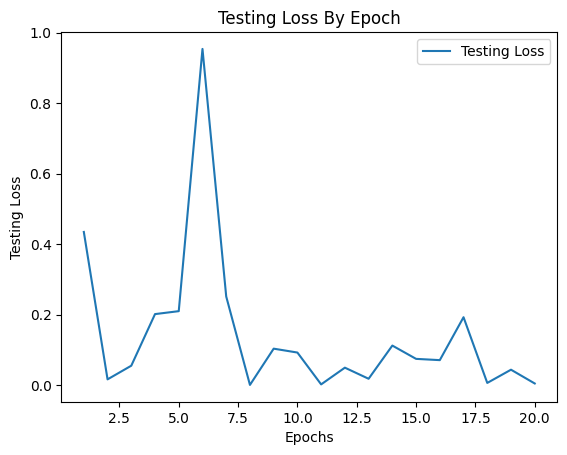

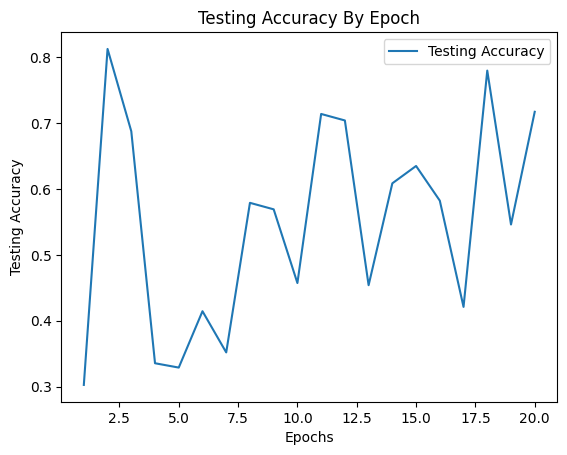

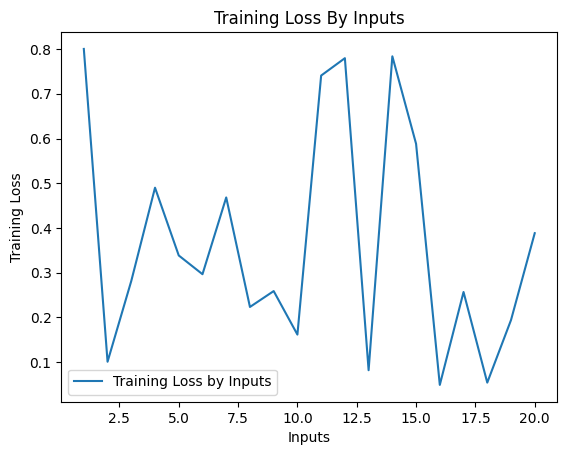

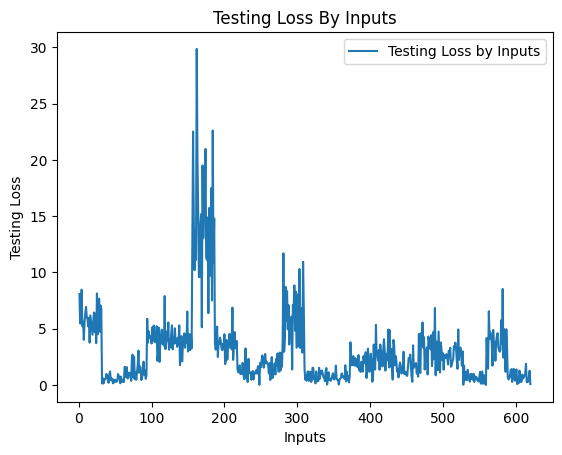

In [64]:
# Training
num_epoch=20
num_epoch_saved=0
lr=0.001
test_size=0


train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []

running_train_losses = []
running_test_losses = []

#For Saving the model
#'/content/drive/My Drive/Colab Notebooks/Saved models/Latest save'
model_name_to_save = 'model.pth'
save_dir=F"/content/drive/My Drive/Colab Notebooks/Saved models/Latest save/{model_name_to_save}"
save_dir_opti=F"/content/drive/My Drive/Colab Notebooks/Saved models/Latest save/optimizer.pth"

print("train")
for epoch in range(num_epoch):
    model.train()
    loss_train= 0.0
    correct = 0
    total = 0
    test_size=0

    if epoch>=1:
      state_dict = torch.load(save_dir)
      state_dict_opti = torch.load(save_dir_opti)
      model.load_state_dict(state_dict)
      optimizer.load_state_dict(state_dict_opti)


    for inputs, labels in train:
      #To Cuda
      inputs=inputs.to(torch.device("cuda:0"))
      labels=labels.to(torch.device("cuda:0"))

      optimizer.zero_grad()
      outputs = model(inputs)
      loss_train = criterion(outputs, labels)
      loss_train.backward()
      optimizer.step()

      #Loss by input Train
      loss_by_input=loss_train.item()
      loss_train += loss_train.item()
      print(f"Epoch {epoch+1}/{num_epoch}, Loss: {loss_by_input}")

      #Accuracy
      total += labels.size(0)
      _, predicted = torch.max(outputs.data, 1)
      correct += (predicted == labels).sum().item()


    # Checking if the loss has improved this epoch. If so it will save that model,
    # otherwise it will just reload the previous  model and continue from there.
    loss_by_epoch=loss_train / len(train)
    print("This epoch:")
    #print(loss_by_epoch.detach().numpy())
    print(loss_by_epoch.detach().cpu().numpy())

    #epoch<=1
    if (True or (loss_by_epoch.detach().cpu().numpy() <= train_losses[-1])):
     #(loss_by_epoch.detach().numpy() <= train_losses[-1])):
      num_epoch_saved=num_epoch_saved+1
      #Save model
      torch.save(model.state_dict(), save_dir)
      torch.save(optimizer.state_dict(), save_dir_opti)
      print('saved')
      #Loss by batch Train
      #train_losses.append(loss_by_epoch.detach().numpy())
      train_losses.append(loss_by_epoch.detach().cpu().numpy())

      running_train_losses.append(loss_by_input) #New

      #Accuracy by batch Train
      accuracy = correct / total
      train_accuracy.append(accuracy)
      print(f"Epoch {epoch+1}/{num_epoch}, Accuracy: {accuracy}")

      #Test
      model.eval()
      loss_test = 0.0
      correct2 = 0
      total2 = 0

      with torch.no_grad():
        for inputs, labels in test:
          #To Cuda
          inputs=inputs.to(torch.device("cuda:0"))
          labels=labels.to(torch.device("cuda:0"))

          outputs = model(inputs)

          test_size+=1

          #Loss Test
          loss_test = criterion(outputs, labels)
          loss_by_input_test=loss_test.item()#New
          loss_test += loss_test.item()

          running_test_losses.append(loss_by_input_test)#New

          #Accuracy Test
          total2 += labels.size(0)
          _, predicted2 = torch.max(outputs.data, 1)
          correct2 += (predicted2 == labels).sum().item()

        loss_by_epoch2=loss_test / len(test)
        #test_losses.append(loss_by_epoch2.detach().numpy())
        test_losses.append(loss_by_epoch2.detach().cpu().numpy())

        accuracy2 = correct2 / total2
        test_accuracy.append(accuracy2)
        print(test_size)

      print("Test end")

print(num_epoch)
print(len(train_losses))
print(len(test_losses))


#Save model
#torch.save(model.state_dict(), save_dir)
#print('saved')

#del model
torch.cuda.empty_cache()

# Plot Loss Train
plt.plot(range(1, num_epoch_saved+1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss By Epoch')
plt.legend()
plt.show()


# Plot Accuracy Train
plt.plot(range(1, num_epoch_saved+1), train_accuracy , label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy By Epoch')
plt.legend()
plt.show()

# Plot Loss Test
plt.plot(range(1, num_epoch_saved+1), test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Testing Loss')
plt.title('Testing Loss By Epoch')
plt.legend()
plt.show()

# Plot Accuracy Test
plt.plot(range(1, num_epoch_saved+1), test_accuracy , label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Testing Accuracy')
plt.title('Testing Accuracy By Epoch')
plt.legend()
plt.show()


#By input
plt.plot(range(1, len(running_train_losses)+1), running_train_losses, label='Training Loss by Inputs')
plt.xlabel('Inputs')
plt.ylabel('Training Loss')
plt.title('Training Loss By Inputs')
plt.legend()
plt.show()

plt.plot(range(1, len(running_test_losses)+1), running_test_losses, label='Testing Loss by Inputs')
plt.xlabel('Inputs')
plt.ylabel('Testing Loss')
plt.title('Testing Loss By Inputs')
plt.legend()
plt.show()


Test
end


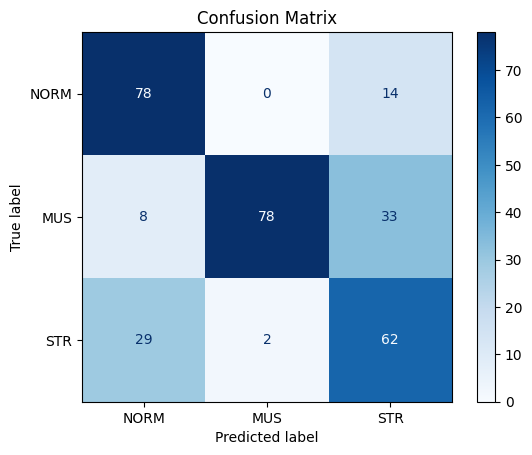

On Testing Data
              precision    recall  f1-score   support

        NORM       0.68      0.85      0.75        92
         MUS       0.97      0.66      0.78       119
         STR       0.57      0.67      0.61        93

    accuracy                           0.72       304
   macro avg       0.74      0.72      0.72       304
weighted avg       0.76      0.72      0.72       304



In [65]:
#Test
#Load model
model_name_to_load = 'model.pth'
save_dir=F"/content/drive/My Drive/Colab Notebooks/Saved models/Latest save/{model_name_to_load}"

state_dict = torch.load(save_dir)
model.load_state_dict(state_dict)
model=model.to(torch.device("cuda:0"))

print('Test')
labels_array = []
predictions = []

model.eval()

with torch.no_grad():
  for inputs, labels in test:
    inputs=inputs.to(torch.device("cuda:0"))
    labels=labels.to(torch.device("cuda:0"))

    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    labels_array.extend(labels.cpu().numpy())
    predictions.extend(predicted.cpu().numpy())

    #labels.extend(labels.cuda().numpy())
    #predictions.extend(predicted.cuda().numpy())
print("end")

# Confusion matrix
c_matrix = confusion_matrix(labels_array, predictions, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(c_matrix, display_labels=['NORM', 'MUS', 'STR'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

#Classification report
print("On Testing Data")
print(classification_report(labels_array, predictions, target_names=['NORM', 'MUS', 'STR']))




In [66]:
#Classification Report on training data
#Load model
model_name_to_load = 'model.pth'
save_dir=F"/content/drive/My Drive/Colab Notebooks/Saved models/Latest save/{model_name_to_load}"

state_dict = torch.load(save_dir)
model.load_state_dict(state_dict)
model=model.to(torch.device("cuda:0"))

with torch.no_grad():
  for inputs, labels in train:
    inputs=inputs.to(torch.device("cuda:0"))
    labels=labels.to(torch.device("cuda:0"))

    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    labels_array.extend(labels.cpu().numpy())
    predictions.extend(predicted.cpu().numpy())

    #labels.extend(labels.cuda().numpy())
    #predictions.extend(predicted.cuda().numpy())
print("end")
#Classification report
print("On Training Data")
print(classification_report(labels_array, predictions, target_names=['NORM', 'MUS', 'STR']))

end
On Training Data
              precision    recall  f1-score   support

        NORM       0.70      0.89      0.78       500
         MUS       0.99      0.68      0.81       500
         STR       0.68      0.70      0.69       500

    accuracy                           0.76      1500
   macro avg       0.79      0.76      0.76      1500
weighted avg       0.79      0.76      0.76      1500

